In [62]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import src.config as config
import os
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def train_model_cv(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train = y_train.values.ravel()
    y_val = y_val.values.ravel()
    y_test = y_test.values.ravel()

    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', verbose=0)
    print("CV Scores:", cv_score)

    acc_mean = cv_score.mean()
    acc_std = cv_score.std()
    print(f"CV Score: {acc_mean:.4f}+-{acc_std:.4f}")

    # Train Model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred)
    print("Validation Accuracy:", acc_val)

    # Predict
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    print("Test Accuracy:", acc_test)
    return model, acc_mean, acc_val, acc_test


def train_extracted_features(MODEL_NAME):
    INPUT_PATH = config.OUTPUT_FEATEXT_DATA

    TRAIN_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'train.csv')
    TRAIN_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_train.csv')
    VAL_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'valid.csv')
    VAL_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_valid.csv')
    TEST_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'test.csv')
    TEST_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_test.csv')

    X_train_prep, y_train = pd.read_csv(TRAIN_DATA_PATH), pd.read_csv(TRAIN_LABELS_PATH)
    X_valid_prep, y_valid = pd.read_csv(VAL_DATA_PATH), pd.read_csv(VAL_LABELS_PATH)
    X_test_prep, y_test = pd.read_csv(TEST_DATA_PATH), pd.read_csv(TEST_LABELS_PATH)

    ls_feats_umap = [col for col in X_train_prep.columns if 'umap' in col]

    sc = StandardScaler()
    X_train_prep[ls_feats_umap] = sc.fit_transform(X_train_prep[ls_feats_umap])
    X_valid_prep[ls_feats_umap] = sc.transform(X_valid_prep[ls_feats_umap])
    X_test_prep[ls_feats_umap] = sc.transform(X_test_prep[ls_feats_umap])

    xgb = XGBClassifier(n_jobs=-1, **{'eta': 0.25,
                                        'gamma': 0.006,
                                        'max_depth': 3,
                                        'reg_lambda': 3.1})
    
    lsvm = LinearSVC(dual='auto')
    svm = SVC(random_state=0, **{'C': 4.5, 'gamma': 0.003})
    
    rf = RandomForestClassifier(n_jobs=-1, random_state=0, **{'ccp_alpha': 0.001,
                                                              'min_samples_leaf': 2,
                                                              'n_estimators': 110})
    vc = VotingClassifier(estimators=[('xgb', xgb), ('lsvm', lsvm), 
                                      ('svm', svm), ('rf', rf)], 
                          voting='hard', n_jobs=-1)

    ls_models = [xgb, lsvm, svm, rf, vc]
    d_results = {}
    for model in ls_models:
        print("Model:", model.__class__.__name__)
        model, acc_mean, acc_val, acc_test = train_model_cv(model, X_train_prep, y_train, 
                                                            X_valid_prep, y_valid, X_test_prep, y_test)
        d_results[model.__class__.__name__] = {'model_name': model.__class__.__name__, 
                                               'trained_model': model, 'CV_accuracy': acc_mean,
                                                'val_accuracy': acc_val, 'test_accuracy': acc_test}
        
    return d_results

model_names = ["EfficientNetB3", "FineTunedVGG16"]

df_model_comp = pd.DataFrame()
for model_name in model_names:
    print("Model:", model_name)
    d_ex = train_extracted_features(model_name)
    df_ = pd.DataFrame(d_ex).T
    df_["extractor"] = model_name
    df_model_comp = pd.concat([df_model_comp, df_], ignore_index=True)

df_model_comp

Model: EfficientNetB3
Model: XGBClassifier
CV Scores: [0.95172414 0.95394089 0.95295567 0.9544335  0.77832512]
CV Score: 0.9183+-0.0700
Validation Accuracy: 0.670344827586207
Test Accuracy: 0.6450150092610334
Model: LinearSVC
CV Scores: [0.82512315 0.84458128 0.85270936 0.86576355 0.59482759]
CV Score: 0.7966+-0.1017
Validation Accuracy: 0.6241379310344828
Test Accuracy: 0.6039471163058057
Model: SVC
CV Scores: [0.89753695 0.90394089 0.9        0.90369458 0.81576355]
CV Score: 0.8842+-0.0343
Validation Accuracy: 0.6462068965517241
Test Accuracy: 0.6319218241042345
Model: RandomForestClassifier
CV Scores: [0.9364532  0.9408867  0.9362069  0.93596059 0.89605911]
CV Score: 0.9291+-0.0166
Validation Accuracy: 0.6606896551724138
Test Accuracy: 0.631027655361819
Model: VotingClassifier
CV Scores: [0.92586207 0.93399015 0.92881773 0.93004926 0.80541872]
CV Score: 0.9048+-0.0498
Validation Accuracy: 0.6558620689655172
Test Accuracy: 0.6431628025803156
Model: FineTunedVGG16
Model: XGBClassifier

model_name                                      trained_model  \
0           XGBClassifier  XGBClassifier(base_score=None, booster=None, c...   
1               LinearSVC                             LinearSVC(dual='auto')   
2                     SVC            SVC(C=4.5, gamma=0.003, random_state=0)   
3  RandomForestClassifier  (DecisionTreeClassifier(ccp_alpha=0.001, max_f...   
4        VotingClassifier  VotingClassifier(estimators=[('xgb',\n        ...   
5           XGBClassifier  XGBClassifier(base_score=None, booster=None, c...   
6               LinearSVC                             LinearSVC(dual='auto')   
7                     SVC            SVC(C=4.5, gamma=0.003, random_state=0)   
8  RandomForestClassifier  (DecisionTreeClassifier(ccp_alpha=0.001, max_f...   
9        VotingClassifier  VotingClassifier(estimators=[('xgb',\n        ...   

  CV_accuracy val_accuracy test_accuracy       extractor  
0    0.918276     0.670345      0.645015  EfficientNetB3  
1    0.796601     0.624138      0.603947  EfficientNetB3  
2    0.884187     0.646207      0.631922  EfficientNetB3  
3    0.929113      0.66069      0.631028  EfficientNetB3  
4    0.904828     0.655862      0.643163  EfficientNetB3  
5    0.995911     0.766897      0.738136  FineTunedVGG16  
6    0.983941     0.781379       0.76758  FineTunedVGG16  
7    0.996108     0.781379      0.764387  FineTunedVGG16  
8    0.995961     0.773103      0.751485  FineTunedVGG16  
9    0.996355         0.78      0.766686  FineTunedVGG16

/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Feature Extraction Model Comparison')

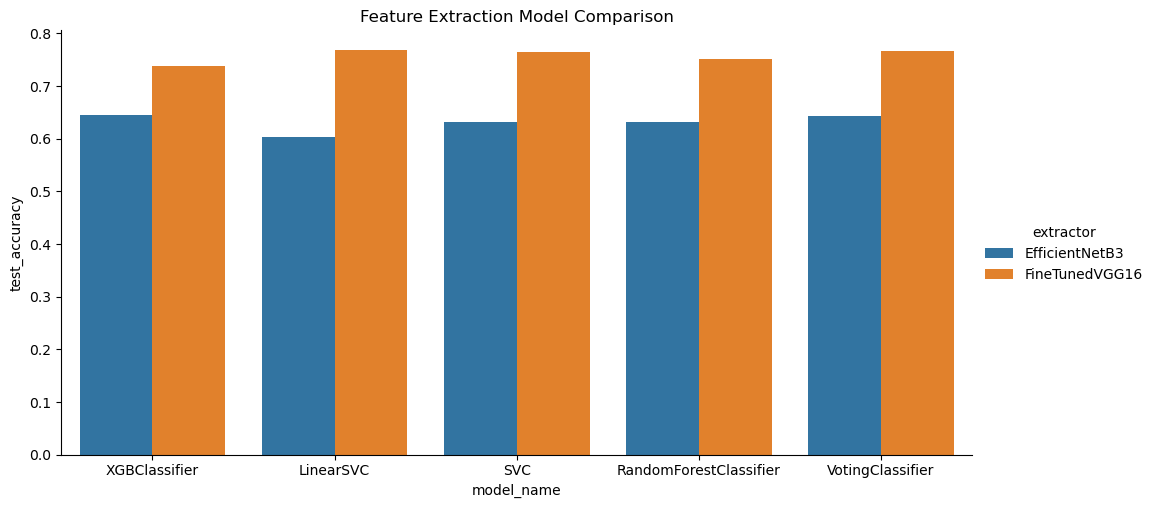

In [63]:
df_model_aux = df_model_comp[['extractor', 'model_name', 'test_accuracy']].copy()
# df_model_aux.set_index(['extractor'], inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(data=df_model_aux, kind='bar', x='model_name', y='test_accuracy', hue='extractor',
            height=5, aspect=2, legend=True);

plt.title("Feature Extraction Model Comparison")

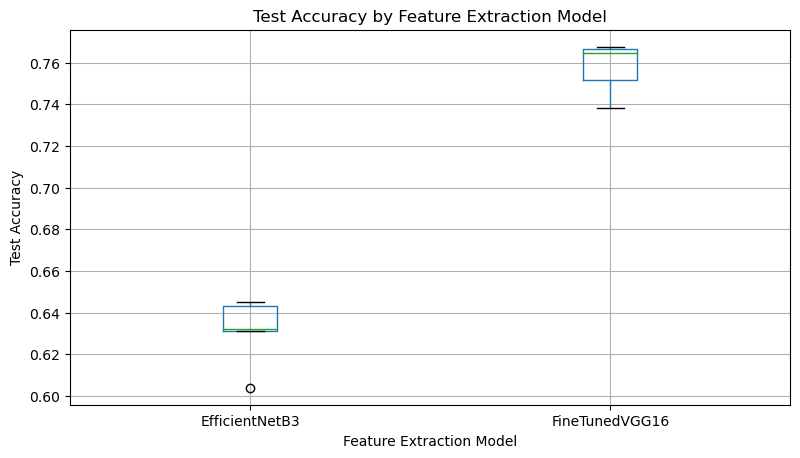

In [64]:
df_model_comp.boxplot(column='test_accuracy', by='extractor', figsize=(9, 5))
plt.title("Test Accuracy by Feature Extraction Model")
plt.xlabel("Feature Extraction Model")
plt.ylabel("Test Accuracy")
plt.suptitle("");

In [76]:
df_ft16 = df_model_comp[df_model_comp['extractor'] == 'FineTunedVGG16'].sort_values(by='test_accuracy', ascending=False)
df_ft16

model_name                                      trained_model  \
6               LinearSVC                             LinearSVC(dual='auto')   
9        VotingClassifier  VotingClassifier(estimators=[('xgb',\n        ...   
7                     SVC            SVC(C=4.5, gamma=0.003, random_state=0)   
8  RandomForestClassifier  (DecisionTreeClassifier(ccp_alpha=0.001, max_f...   
5           XGBClassifier  XGBClassifier(base_score=None, booster=None, c...   

  CV_accuracy val_accuracy test_accuracy       extractor  
6    0.983941     0.781379       0.76758  FineTunedVGG16  
9    0.996355         0.78      0.766686  FineTunedVGG16  
7    0.996108     0.781379      0.764387  FineTunedVGG16  
8    0.995961     0.773103      0.751485  FineTunedVGG16  
5    0.995911     0.766897      0.738136  FineTunedVGG16

In [75]:
df_effb3_ = df_model_comp[df_model_comp['extractor'] == 'EfficientNetB3'].sort_values(by='test_accuracy', ascending=False)
df_effb3_

model_name                                      trained_model  \
0           XGBClassifier  XGBClassifier(base_score=None, booster=None, c...   
4        VotingClassifier  VotingClassifier(estimators=[('xgb',\n        ...   
2                     SVC            SVC(C=4.5, gamma=0.003, random_state=0)   
3  RandomForestClassifier  (DecisionTreeClassifier(ccp_alpha=0.001, max_f...   
1               LinearSVC                             LinearSVC(dual='auto')   

  CV_accuracy val_accuracy test_accuracy       extractor  
0    0.918276     0.670345      0.645015  EfficientNetB3  
4    0.904828     0.655862      0.643163  EfficientNetB3  
2    0.884187     0.646207      0.631922  EfficientNetB3  
3    0.929113      0.66069      0.631028  EfficientNetB3  
1    0.796601     0.624138      0.603947  EfficientNetB3

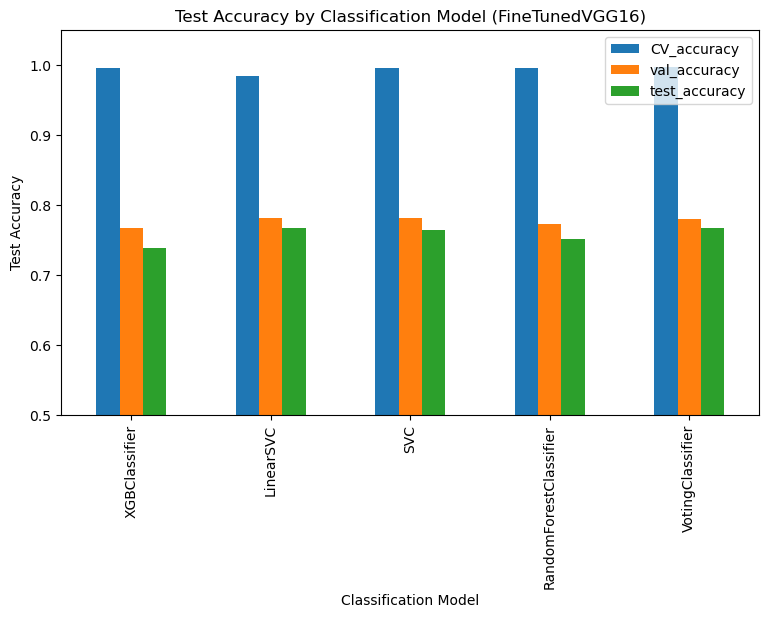

In [93]:
df_ft16_aux = df_model_comp[df_model_comp['extractor'] == 'FineTunedVGG16']
df_ft16_aux.plot( kind="bar", column='test_accuracy', x="model_name", figsize=(9, 5))
plt.title("Test Accuracy by Classification Model (FineTunedVGG16)")
plt.xlabel("Classification Model")
plt.ylabel("Test Accuracy")
plt.ylim(0.5, 1.05)
plt.suptitle("");

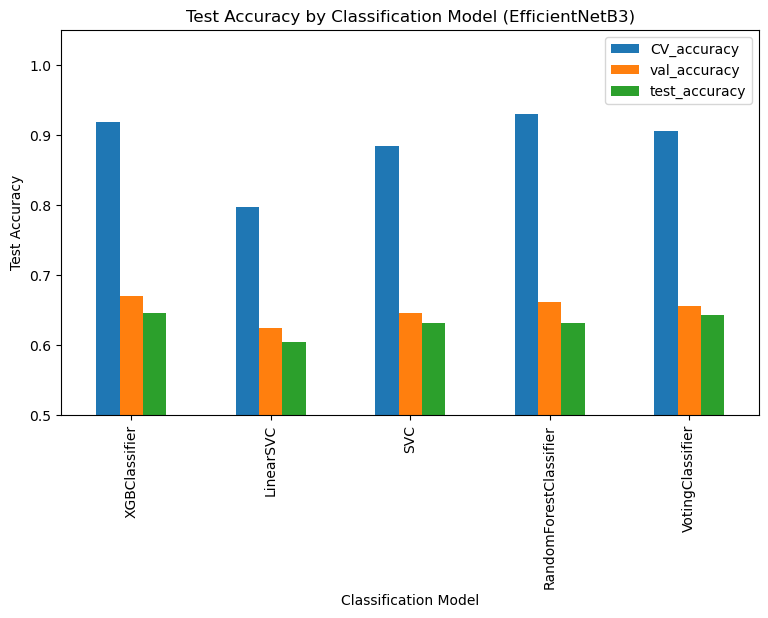

In [94]:
df_effb3_aux = df_model_comp[df_model_comp['extractor'] == 'EfficientNetB3']#.sort_values(by='test_accuracy', ascending=False)

df_effb3_aux.plot( kind="bar", column='test_accuracy', x="model_name", figsize=(9, 5))
plt.title("Test Accuracy by Classification Model (EfficientNetB3)")
plt.xlabel("Classification Model")
plt.ylabel("Test Accuracy")
plt.ylim(0.5, 1.05)
plt.suptitle("");

Text(0.5, 1.0, 'Feature Importance for FineTunedVGG16 + XGBoost')

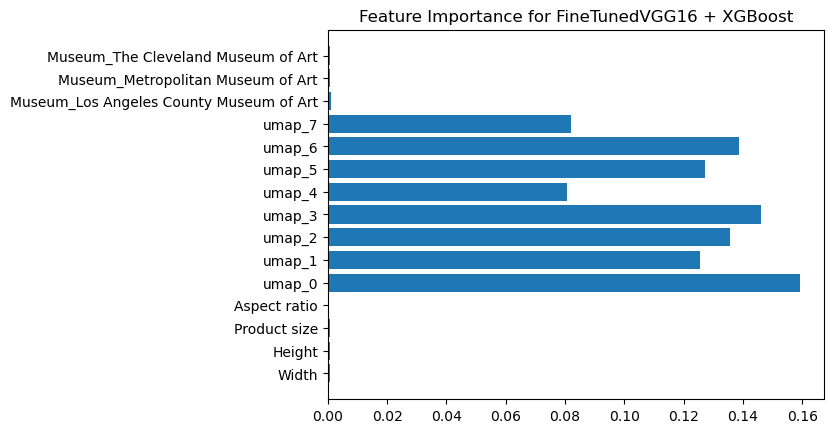

In [67]:
df_effb3 = df_model_comp[df_model_comp['extractor'] == 'FineTunedVGG16']
xgb_imp = df_effb3[df_effb3["model_name"] == 'XGBClassifier']['trained_model'].iloc[0]

plt.barh(xgb_imp.feature_names_in_, xgb_imp.feature_importances_)
plt.title("Feature Importance for FineTunedVGG16 + XGBoost")

Text(0.5, 1.0, 'Feature Importance for FineTunedVGG16 + RandomForestClassifier')

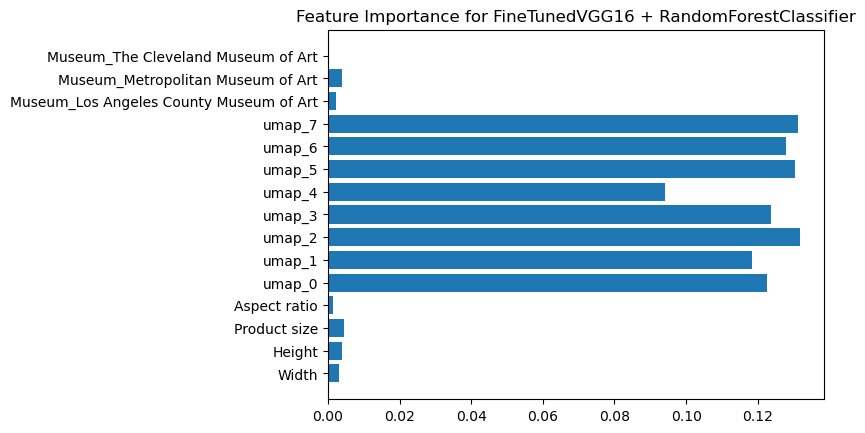

In [68]:
df_effb3 = df_model_comp[df_model_comp['extractor'] == 'FineTunedVGG16']
rf_imp = df_effb3[df_effb3["model_name"] == 'RandomForestClassifier']['trained_model'].iloc[0]

plt.barh(rf_imp.feature_names_in_, rf_imp.feature_importances_)
plt.title("Feature Importance for FineTunedVGG16 + RandomForestClassifier")

In [69]:
import numpy as np
df_effb3 = df_model_comp[df_model_comp['extractor'] == 'EfficientNetB3']
lsvc_imp = df_effb3[df_effb3["model_name"] == 'LinearSVC']['trained_model'].iloc[0].coef_
lsvc_imp = np.abs(lsvc_imp.mean(axis=0)) / np.abs(lsvc_imp.mean(axis=0)).sum()

# plt.barh(rf_imp.feature_names_in_, rf_imp.feature_importances_)
# plt.title("Feature Importance for EfficientNetB3 + RandomForestClassifier")


In [70]:
lsvc_imp

array([0.01668147, 0.01650813, 0.04389155, 0.00143446, 0.0302184 ,
       0.02842566, 0.01474443, 0.0449481 , 0.07774836, 0.06021717,
       0.03672973, 0.002627  , 0.2450453 , 0.17168193, 0.20909831])

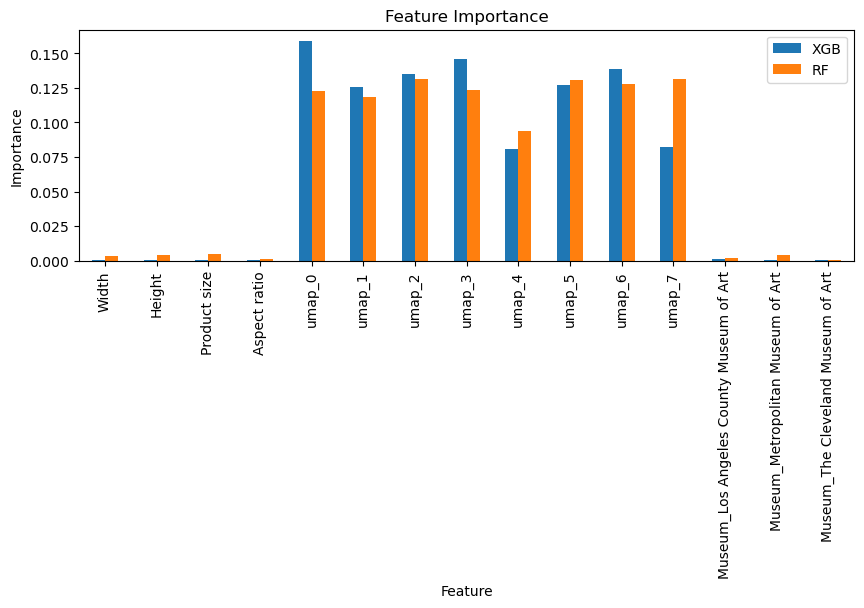

In [71]:
df_imp = pd.DataFrame({'XGB': xgb_imp.feature_importances_, 'RF': rf_imp.feature_importances_}, index=xgb_imp.feature_names_in_)
# df_imp = df_imp.sort_values(by='XGB', ascending=False)
df_imp.plot(kind='bar', figsize=(10, 3), title='Feature Importance', xlabel='Feature', ylabel='Importance');

In [17]:
# Load X_train, y_train, X_test, y_test
INPUT_PATH = config.OUTPUT_FEATTOP_DATA

TRAIN_DATA_PATH = os.path.join(INPUT_PATH, 'EfficientNetB3', 'train.csv')
TRAIN_LABELS_PATH = os.path.join(INPUT_PATH, 'EfficientNetB3', 'y_train.csv')


X_train_prep, y_train = pd.read_csv(TRAIN_DATA_PATH), pd.read_csv(TRAIN_LABELS_PATH)

In [23]:
X_train_prep[umap_feats]

umap_0    umap_1    umap_2     umap_3    umap_4     umap_5  \
0       8.861486  5.687942  3.542317  10.503372  6.342788  10.244471   
1       9.275366  5.785476  3.288392  10.522595  6.079661  10.244962   
2       9.017611  5.871374  3.413760  10.477140  6.170753  10.176578   
3       8.888192  5.826143  3.442809  10.432126  6.368913  10.112333   
4       8.223749  5.837707  3.844190  10.156062  6.772964   9.894257   
...          ...       ...       ...        ...       ...        ...   
20295  11.624775  2.277772  3.691400  11.166593  9.297000  14.736204   
20296  11.547504  2.272046  3.752462  11.192346  9.298937  14.809742   
20297  11.672392  2.287406  3.632502  11.123696  9.221782  14.788664   
20298  11.718847  2.132331  3.667454  11.254521  9.445282  14.567406   
20299  11.896852  2.172917  3.482230  11.133457  9.346400  14.487454   

         umap_6    umap_7  
0     -2.598467 -0.004810  
1     -2.477178 -0.448478  
2     -2.594188 -0.191072  
3     -2.111128  0.081855  
4     -1.721457  0.829581  
...         ...       ...  
20295 -0.346267 -4.660994  
20296 -0.430908 -4.684768  
20297 -0.369457 -4.701803  
20298 -0.235256 -4.713800  
20299 -0.104937 -4.693895  

[20300 rows x 8 columns]

/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


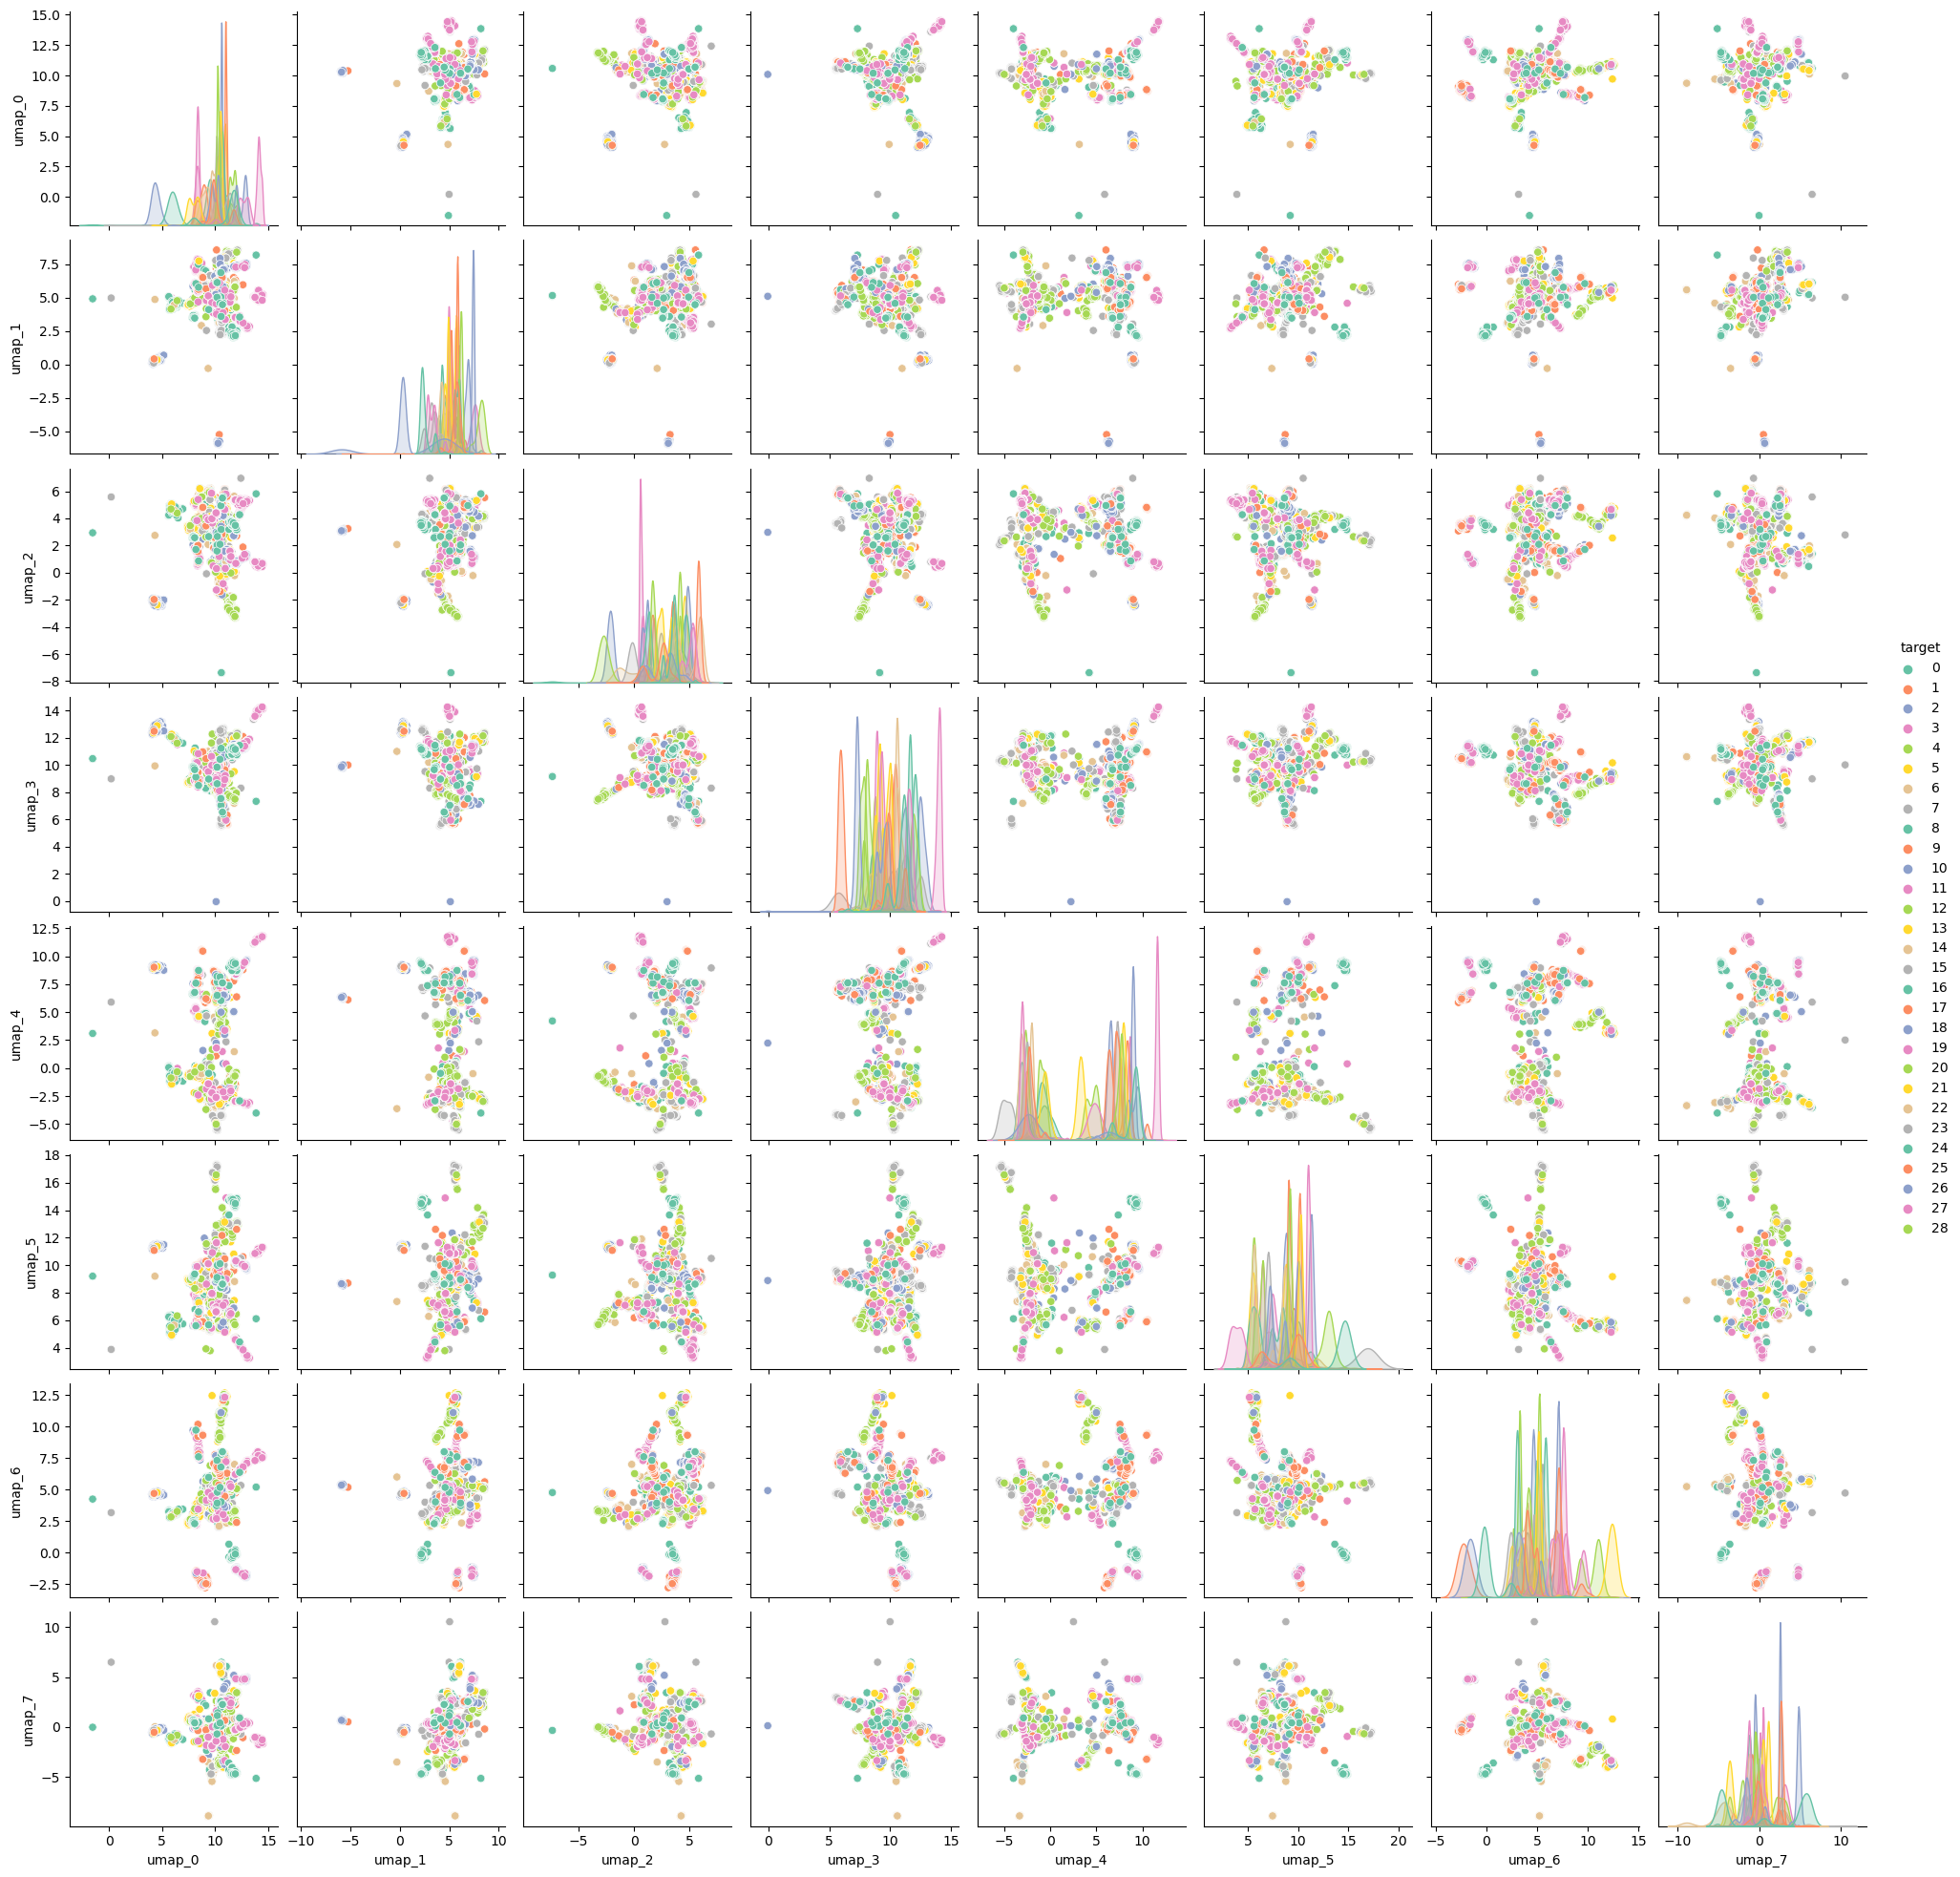

In [16]:
df_model_comp.sort_values(by='test_accuracy', ascending=False)

model_name                                      trained_model  \
14        VotingClassifier  VotingClassifier(estimators=[('xgb',\n        ...   
19        VotingClassifier  VotingClassifier(estimators=[('xgb',\n        ...   
4         VotingClassifier  VotingClassifier(estimators=[('xgb',\n        ...   
9         VotingClassifier  VotingClassifier(estimators=[('xgb',\n        ...   
0            XGBClassifier  XGBClassifier(base_score=None, booster=None, c...   
2                      SVC                                              SVC()   
5            XGBClassifier  XGBClassifier(base_score=None, booster=None, c...   
12                     SVC                                              SVC()   
10           XGBClassifier  XGBClassifier(base_score=None, booster=None, c...   
3   RandomForestClassifier  (DecisionTreeClassifier(max_features='sqrt', r...   
17                     SVC                                              SVC()   
7                      SVC                                              SVC()   
18  RandomForestClassifier  (DecisionTreeClassifier(max_features='sqrt', r...   
8   RandomForestClassifier  (DecisionTreeClassifier(max_features='sqrt', r...   
15           XGBClassifier  XGBClassifier(base_score=None, booster=None, c...   
13  RandomForestClassifier  (DecisionTreeClassifier(max_features='sqrt', r...   
11               LinearSVC                             LinearSVC(dual='auto')   
1                LinearSVC                             LinearSVC(dual='auto')   
6                LinearSVC                             LinearSVC(dual='auto')   
16               LinearSVC                             LinearSVC(dual='auto')   

   CV_accuracy val_accuracy test_accuracy       extractor  
14    0.899015     0.668966      0.648783  EfficientNetB0  
19    0.901379     0.663448      0.648528  EfficientNetB3  
4     0.897882     0.666207      0.647634        ResNet50  
9     0.896995     0.663448      0.644951           VGG16  
0     0.919163     0.667586      0.644376        ResNet50  
2     0.877291      0.66069      0.644121        ResNet50  
5     0.919261     0.664828      0.642013           VGG16  
12    0.876995     0.656552      0.641694  EfficientNetB0  
10    0.921182     0.668966      0.641374  EfficientNetB0  
3     0.919951     0.673793       0.64048        ResNet50  
17    0.881182     0.653793      0.639969  EfficientNetB3  
7     0.875271     0.655172      0.639267           VGG16  
18    0.910985     0.666897      0.639011  EfficientNetB3  
8     0.918916     0.666207       0.63882           VGG16  
15    0.920887     0.665517      0.637287  EfficientNetB3  
13    0.914433     0.668966      0.633774  EfficientNetB0  
11    0.811084     0.631724      0.615444  EfficientNetB0  
1     0.803842     0.631724      0.611037        ResNet50  
6     0.791379         0.62      0.602223           VGG16  
16    0.780887     0.627586      0.600307  EfficientNetB3

In [ ]:
xgb_imp = d_results['XGBClassifier']['model'].feature_importances_
rf_imp = d_results['RandomForestClassifier']['model'].feature_importances_
lsvc_imp = np.abs(d_results['LinearSVC']['model'].coef_).mean(axis=0)
lsvc_imp = lsvc_imp / lsvc_imp.sum()

In [19]:
import pandas as pd
import src.config as config
import os

MODEL_NAME = 'FineTunedVGG16'
INPUT_PATH = config.OUTPUT_FEATEXT_DATA

TRAIN_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'train.csv')
TRAIN_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_train.csv')
VAL_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'valid.csv')
VAL_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_valid.csv')
TEST_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'test.csv')
TEST_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_test.csv')

X_train_prep, y_train = pd.read_csv(TRAIN_DATA_PATH), pd.read_csv(TRAIN_LABELS_PATH)
X_valid_prep, y_valid = pd.read_csv(VAL_DATA_PATH), pd.read_csv(VAL_LABELS_PATH)
X_test_prep, y_test = pd.read_csv(TEST_DATA_PATH), pd.read_csv(TEST_LABELS_PATH)

ls_feats_umap = [col for col in X_train_prep.columns if 'umap' in col]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_prep[ls_feats_umap] = sc.fit_transform(X_train_prep[ls_feats_umap])
X_valid_prep[ls_feats_umap] = sc.transform(X_valid_prep[ls_feats_umap])
X_test_prep[ls_feats_umap] = sc.transform(X_test_prep[ls_feats_umap])

print("Data Size:")
print("Train:", X_train_prep.shape, y_train.shape)
print("Valid:", X_valid_prep.shape, y_valid.shape)
print("Test:", X_test_prep.shape, y_test.shape)

Data Size:
Train: (20300, 15) (20300, 1)
Valid: (1450, 15) (1450, 1)
Test: (15657, 15) (15657, 1)


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


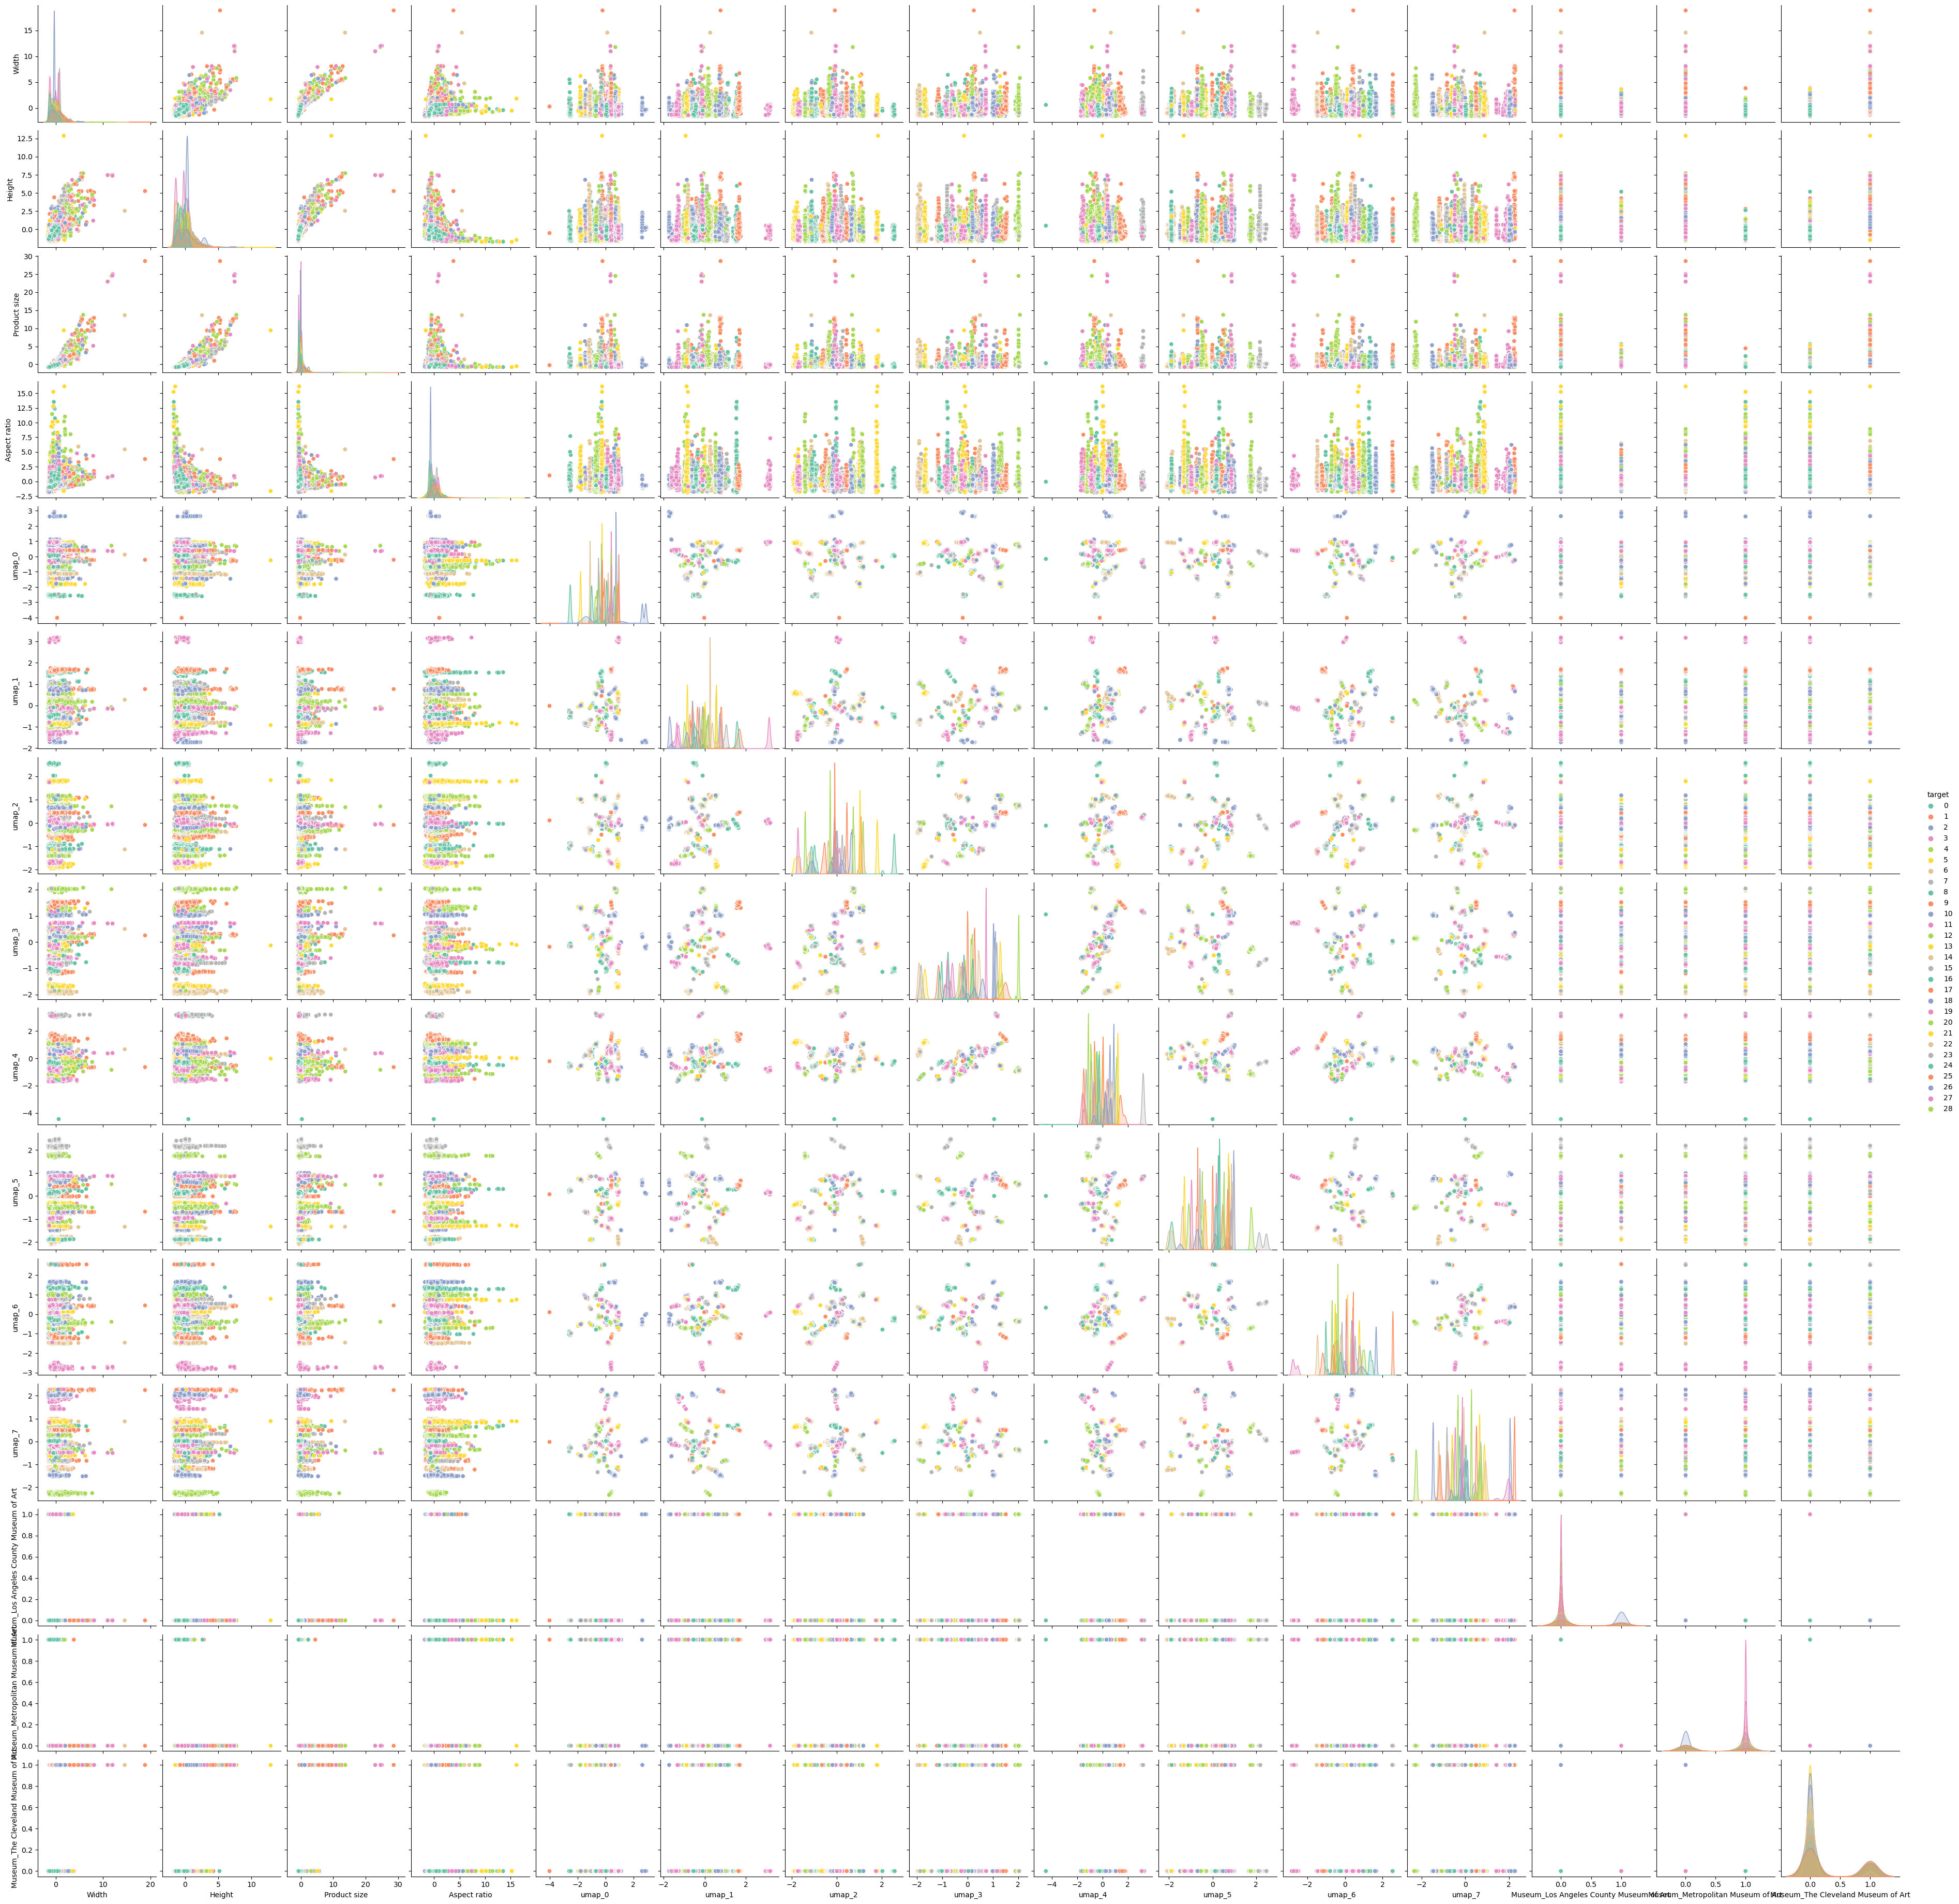

In [74]:
umap_feats = [col for col in X_train_prep.columns]
df_plot = X_train_prep[umap_feats].copy()
df_plot['target'] = y_train
sns.pairplot(df_plot, hue='target', palette='Set2');

In [47]:
from bayes_opt import BayesianOptimization, UtilityFunction
# Numpy import

import numpy as np



# SK Learn imports

from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def internal_method(C, random_state):

    # C: SVC hyper parameter to optimize for.
    # if penalty < 0.5:
    #     penalty = 'l1'
    # else:
    #     penalty = 'l2'
    
    model = LinearSVC( C=C, dual='auto', random_state=int(random_state))
    f = cross_val_score(model, X_train_prep, y_train.values.ravel(), cv=5, scoring='accuracy', verbose=0).mean()
    # y_pred = model.predict(X_valid_prep)
    # f = accuracy_score(y_valid.values.ravel(), y_pred)
    return f

# bayes_opt requires this to be a dictionary.
bds = {"C": (0.1, 10), 'random_state': (0, 100)}

# Create a BayesianOptimization optimizer and optimize the function
optimizer = BayesianOptimization(f = internal_method,
                                 pbounds = bds,
                                 random_state = 7,
                                 verbose=2)

optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   |     C     | random... |
-------------------------------------------------
| 1         | 0.9864    | 0.8555    | 77.99     |
| 2         | 0.9817    | 4.44      | 72.35     |
| 3         | 0.9772    | 9.782     | 53.85     |
| 4         | 0.9802    | 5.061     | 7.205     |
| 5         | 0.9824    | 2.758     | 49.99     |
| 6         | 0.9792    | 6.824     | 80.37     |
| 7         | 0.9823    | 3.871     | 6.594     |
| 8         | 0.9823    | 2.953     | 90.96     |
| 9         | 0.9827    | 2.213     | 45.21     |
| 10        | 0.9784    | 9.319     | 2.49      |
| 11        | 0.9823    | 3.227     | 78.55     |
| 12        | 0.9924    | 0.6838    | 76.88     |
| 13        | 0.9833    | 1.278     | 76.45     |
| 14        | 0.9844    | 0.9727    | 77.25     |
| 15        | 0.9902    | 0.7605    | 76.77     |
| 16        | 0.9941    | 0.4397    | 76.91     |
| 17        | 0.9945    | 0.2072    | 77.26     |
| 18        | 0.9942    | 0.2226    | 77.75     |


In [48]:
optimizer.max

{'target': 0.9957635467980296,
 'params': {'C': 0.12560788650248703, 'random_state': 80.97612491250806}}

In [49]:
from bayes_opt import BayesianOptimization, UtilityFunction
# Numpy import

import numpy as np



# SK Learn imports

from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def internal_method(n_estimators, min_samples_leaf, ccp_alpha):

    # C: SVC hyper parameter to optimize for.
    # if penalty < 0.5:
    #     penalty = 'l1'
    # else:
    #     penalty = 'l2'
    
    model = RandomForestClassifier(random_state=0,
                                   n_estimators=int(n_estimators),
                                      n_jobs=-1,
                                    min_samples_leaf=int(min_samples_leaf),
                                    ccp_alpha=ccp_alpha)
    
    f = cross_val_score(model, X_train_prep, y_train.values.ravel(), cv=5, scoring='accuracy', verbose=0).mean()
    return f

# bayes_opt requires this to be a dictionary.
bds = {"n_estimators": (50, 500), 'min_samples_leaf': (2, 50),
       'ccp_alpha': (0.001, 0.05)}

# Create a BayesianOptimization optimizer and optimize the function
optimizer = BayesianOptimization(f = internal_method,
                                 pbounds = bds,
                                 random_state = 7,
                                 verbose=2)

optimizer.maximize(init_points=5, n_iter=25)

|   iter    |  target   | ccp_alpha | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.9946    | 0.004739  | 39.44     | 247.3     |
| 2         | 0.5978    | 0.03645   | 48.94     | 292.3     |
| 3         | 0.9946    | 0.02555   | 5.458     | 170.8     |
| 4         | 0.9947    | 0.02549   | 34.6      | 411.7     |
| 5         | 0.9947    | 0.01967   | 5.165     | 179.7     |
| 6         | 0.9948    | 0.01706   | 33.77     | 410.1     |
| 7         | 0.03448   | 0.05      | 50.0      | 202.4     |
| 8         | 0.9959    | 0.001     | 2.0       | 252.8     |
| 9         | 0.9959    | 0.001     | 2.0       | 436.9     |
| 10        | 0.9949    | 0.00266   | 34.29     | 468.1     |
| 11        | 0.9948    | 0.0137    | 2.266     | 493.9     |
| 12        | 0.996     | 0.001     | 2.0       | 111.9     |
| 13        | 0.9946    | 0.02427   | 2.236     | 65.73     |
| 14        | 0.9942    | 0.03375   | 42.66     | 87.75     |
| 15    

In [50]:
optimizer.max

{'target': 0.995960591133005,
 'params': {'ccp_alpha': 0.001,
  'min_samples_leaf': 2.0,
  'n_estimators': 111.87591075360078}}

In [51]:
from bayes_opt import BayesianOptimization, UtilityFunction
# Numpy import

import numpy as np



# SK Learn imports

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def internal_method(eta, max_depth, reg_lambda, gamma):

    # C: SVC hyper parameter to optimize for.
    # if penalty < 0.5:
    #     penalty = 'l1'
    # else:
    #     penalty = 'l2'
    
    model = XGBClassifier(random_state=0,
                           eta=eta,
                            n_jobs=-1,
                            max_depth=int(max_depth),
                            reg_lambda=reg_lambda,
                            gamma=gamma)
    
    model.fit(X_train_prep, y_train.values.ravel())
    f = cross_val_score(model, X_train_prep, y_train.values.ravel(), cv=5, scoring='accuracy', verbose=0).mean()

    return f

# bayes_opt requires this to be a dictionary.
bds = {"eta": (0.001, 0.5), 'max_depth': (2, 10),
       'reg_lambda': (0.05, 10.), 'gamma': (0.0001, 0.01)}

# Create a BayesianOptimization optimizer and optimize the function
optimizer = BayesianOptimization(f = internal_method,
                                 pbounds = bds,
                                 random_state = 7,
                                 verbose=2)

optimizer.maximize(init_points=5, n_iter=25)

|   iter    |  target   |    eta    |   gamma   | max_depth | reg_la... |
-------------------------------------------------------------------------
| 1         | 0.9957    | 0.03908   | 0.007821  | 5.507     | 7.248     |
| 2         | 0.9957    | 0.489     | 0.005431  | 6.009     | 0.7669    |
| 3         | 0.996     | 0.135     | 0.005049  | 7.434     | 8.047     |
| 4         | 0.9961    | 0.1911    | 0.0007528 | 4.305     | 9.1       |
| 5         | 0.9958    | 0.1075    | 0.004576  | 9.45      | 0.2977    |
| 6         | 0.9958    | 0.09709   | 0.003848  | 7.482     | 6.673     |
| 7         | 0.9961    | 0.213     | 0.00299   | 4.46      | 4.476     |
| 8         | 0.996     | 0.3924    | 0.00782   | 6.17      | 1.138     |
| 9         | 0.9959    | 0.3231    | 0.006336  | 3.04      | 5.918     |
| 10        | 0.9958    | 0.4447    | 0.009928  | 3.356     | 1.575     |
| 11        | 0.9961    | 0.1496    | 0.003757  | 3.399     | 3.03      |
| 12        | 0.996     | 0.2606    | 

In [52]:
optimizer.max

{'target': 0.9962561576354678,
 'params': {'eta': 0.25339162846261826,
  'gamma': 0.006234665795739654,
  'max_depth': 3.460391641354139,
  'reg_lambda': 3.0892095779004722}}

In [53]:
from bayes_opt import BayesianOptimization, UtilityFunction
# Numpy import

import numpy as np



# SK Learn imports

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def internal_method(C, gamma):

    # C: SVC hyper parameter to optimize for.
    # if penalty < 0.5:
    #     penalty = 'l1'
    # else:
    #     penalty = 'l2'
    
    model = SVC(random_state=0,
                C=C, gamma=gamma)
    
    model.fit(X_train_prep, y_train.values.ravel())
    f = cross_val_score(model, X_train_prep, y_train.values.ravel(), cv=5, scoring='accuracy', verbose=0).mean()
    return f

# bayes_opt requires this to be a dictionary.
bds = {"C": (0.1, 10.), 'gamma': (0.0001, 0.01)}

# Create a BayesianOptimization optimizer and optimize the function
optimizer = BayesianOptimization(f = internal_method,
                                 pbounds = bds,
                                 random_state = 7,
                                 verbose=2)

optimizer.maximize(init_points=5, n_iter=25)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.9947    | 0.8555    | 0.007821  |
| 2         | 0.9958    | 4.44      | 0.007262  |
| 3         | 0.9957    | 9.782     | 0.005431  |
| 4         | 0.9944    | 5.061     | 0.0008133 |
| 5         | 0.996     | 2.758     | 0.005049  |
| 6         | 0.9959    | 2.761     | 0.005897  |
| 7         | 0.9959    | 2.802     | 0.006316  |
| 8         | 0.9949    | 2.688     | 0.002221  |
| 9         | 0.996     | 8.766     | 0.002015  |
| 10        | 0.996     | 8.814     | 0.00221   |
| 11        | 0.9944    | 5.944     | 0.0004959 |
| 12        | 0.9943    | 2.866     | 0.001331  |
| 13        | 0.9954    | 8.864     | 0.008324  |
| 14        | 0.9955    | 8.717     | 0.007707  |
| 15        | 0.9953    | 4.386     | 0.009891  |
| 16        | 0.9961    | 4.492     | 0.003055  |
| 17        | 0.9955    | 4.536     | 0.008308  |
| 18        | 0.9958    | 9.722     | 0.004312  |


In [54]:
optimizer.max

{'target': 0.9961083743842364,
 'params': {'C': 4.491866218127903, 'gamma': 0.0030551788460546217}}